In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score 


In [ ]:
dataset=pd.read_csv("flightdata.csv")

In [ ]:
dataset.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11231 non-null  int64  
 1   QUARTER              11231 non-null  int64  
 2   MONTH                11231 non-null  int64  
 3   DAY_OF_MONTH         11231 non-null  int64  
 4   DAY_OF_WEEK          11231 non-null  int64  
 5   UNIQUE_CARRIER       11231 non-null  object 
 6   TAIL_NUM             11231 non-null  object 
 7   FL_NUM               11231 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11231 non-null  int64  
 9   ORIGIN               11231 non-null  object 
 10  DEST_AIRPORT_ID      11231 non-null  int64  
 11  DEST                 11231 non-null  object 
 12  CRS_DEP_TIME         11231 non-null  int64  
 13  DEP_TIME             11124 non-null  float64
 14  DEP_DELAY            11124 non-null  float64
 15  DEP_DEL15            11124 non-null 

In [ ]:
dataset = dataset.drop('Unnamed: 25', axis=1)
dataset.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

In [ ]:
#filter the dataset to eliminate columns that aren't relevant to a predictive model.
dataset = dataset[["FL_NUM", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_ARR_TIME", "DEP_DEL15", "ARR_DEL15","ARR_DELAY"]]
dataset.isnull().sum()

FL_NUM            0
MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_ARR_TIME      0
DEP_DEL15       107
ARR_DEL15       188
ARR_DELAY       188
dtype: int64

In [ ]:
dataset[dataset.isnull().any(axis=1)].head(10)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ARR_DELAY
177,2834,1,9,6,MSP,SEA,852,0.0,NaN,NaN
179,86,1,10,7,MSP,DTW,1632,NaN,NaN,NaN
184,557,1,10,7,MSP,DTW,912,0.0,NaN,NaN
210,1096,1,10,7,DTW,MSP,1303,NaN,NaN,NaN
478,1542,1,22,5,SEA,JFK,723,NaN,NaN,NaN
481,1795,1,22,5,ATL,JFK,2014,NaN,NaN,NaN
491,2312,1,22,5,MSP,JFK,2149,NaN,NaN,NaN
499,423,1,23,6,JFK,ATL,1600,NaN,NaN,NaN
500,425,1,23,6,JFK,ATL,1827,NaN,NaN,NaN
501,427,1,23,6,JFK,SEA,1053,NaN,NaN,NaN


In [ ]:
dataset['DEP_DEL15'].mode()

0    0.0
Name: DEP_DEL15, dtype: float64

In [ ]:
#replace the missing values with 15.
dataset = dataset.fillna({'ARR_DEL15': 1})
dataset = dataset.fillna({'DEP_DEL15': 0})
dataset.iloc[177:185]

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ARR_DELAY
177,2834,1,9,6,MSP,SEA,852,0.0,1.0,NaN
178,2839,1,9,6,DTW,JFK,1724,0.0,0.0,-15.0
179,86,1,10,7,MSP,DTW,1632,0.0,1.0,NaN
180,87,1,10,7,DTW,MSP,1649,1.0,0.0,14.0
181,423,1,10,7,JFK,ATL,1600,0.0,0.0,7.0
182,440,1,10,7,JFK,ATL,849,0.0,0.0,-14.0
183,485,1,10,7,JFK,SEA,1945,1.0,0.0,10.0
184,557,1,10,7,MSP,DTW,912,0.0,1.0,NaN


In [ ]:
import math

for index, row in dataset.iterrows():
  dataset.loc[index, 'CRS_ARR_TIME'] = math.floor(row['CRS_ARR_TIME'] / 100)
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ARR_DELAY
0,1399,1,1,5,ATL,SEA,21,0.0,0.0,-41.0
1,1476,1,1,5,DTW,MSP,14,0.0,0.0,4.0
2,1597,1,1,5,ATL,SEA,12,0.0,0.0,-33.0
3,1768,1,1,5,SEA,MSP,13,0.0,0.0,10.0
4,1823,1,1,5,SEA,DTW,6,0.0,0.0,8.0


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['DEST'] = le.fit_transform(dataset['DEST'])
dataset['ORIGIN'] = le.fit_transform(dataset['ORIGIN'])

In [ ]:
dataset.head(5)

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ARR_DELAY
0,1399,1,1,5,0,4,21,0.0,0.0,-41.0
1,1476,1,1,5,1,3,14,0.0,0.0,4.0
2,1597,1,1,5,0,4,12,0.0,0.0,-33.0
3,1768,1,1,5,4,3,13,0.0,0.0,10.0
4,1823,1,1,5,4,1,6,0.0,0.0,8.0


In [ ]:
dataset['ORIGIN'].unique()

array([0, 1, 4, 3, 2])

In [ ]:
dataset = pd.get_dummies(dataset, columns=['ORIGIN', 'DEST'])
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ARR_DELAY,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
0,1399,1,1,5,21,0.0,0.0,-41.0,1,0,0,0,0,0,0,0,0,1
1,1476,1,1,5,14,0.0,0.0,4.0,0,1,0,0,0,0,0,0,1,0
2,1597,1,1,5,12,0.0,0.0,-33.0,1,0,0,0,0,0,0,0,0,1
3,1768,1,1,5,13,0.0,0.0,10.0,0,0,0,0,1,0,0,0,1,0
4,1823,1,1,5,6,0.0,0.0,8.0,0,0,0,0,1,0,1,0,0,0


In [ ]:
x = dataset.iloc[:, 0:8].values
y = dataset.iloc[:, 8:9].values

In [ ]:
x

array([[ 1.399e+03,  1.000e+00,  1.000e+00, ...,  0.000e+00,  0.000e+00,
        -4.100e+01],
       [ 1.476e+03,  1.000e+00,  1.000e+00, ...,  0.000e+00,  0.000e+00,
         4.000e+00],
       [ 1.597e+03,  1.000e+00,  1.000e+00, ...,  0.000e+00,  0.000e+00,
        -3.300e+01],
       ...,
       [ 1.823e+03,  1.200e+01,  3.000e+01, ...,  0.000e+00,  0.000e+00,
        -1.600e+01],
       [ 1.901e+03,  1.200e+01,  3.000e+01, ...,  0.000e+00,  0.000e+00,
        -5.000e+00],
       [ 2.005e+03,  1.200e+01,  3.000e+01, ...,  0.000e+00,  0.000e+00,
        -1.200e+01]])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
z=oh.fit_transform(x[:,4:5]).toarray()
t=oh.fit_transform(x[:,5:6]).toarray()
#x=np.delete(x,[4,7],axis=1)

In [ ]:
z

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
t

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
x=np.delete(x,[4,5],axis=1)

In [ ]:
dataset.describe()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ARR_DELAY,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4
count,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11043.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000
mean,1334.325617,6.628973,15.790758,3.960199,15.067314,0.141483,0.139168,-2.573123,0.276022,0.195975,0.122340,0.225982,0.179681,0.286795,0.196866,0.116820,0.221975,0.177544
std,811.875227,3.354678,8.782056,1.995257,5.023534,0.348535,0.346138,39.232521,0.447048,0.396967,0.327693,0.418246,0.383939,0.452285,0.397648,0.321219,0.415593,0.382146
min,7.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,624.000000,4.000000,8.000000,2.000000,11.000000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1267.000000,7.000000,16.000000,4.000000,15.000000,0.000000,0.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2032.000000,9.000000,23.000000,6.000000,19.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2853.000000,12.000000,31.000000,7.000000,23.000000,1.000000,1.000000,615.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<ipython-input-31-43f5c122a6ef>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset.MONTH)


<Axes: xlabel='MONTH', ylabel='Density'>

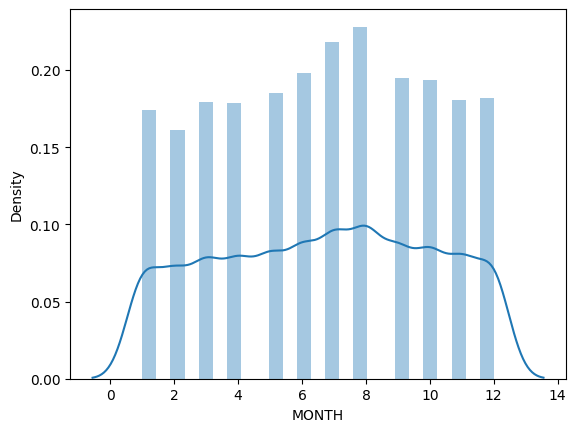

In [ ]:
sns.distplot(dataset.MONTH)

<Axes: xlabel='ARR_DELAY', ylabel='ARR_DEL15'>

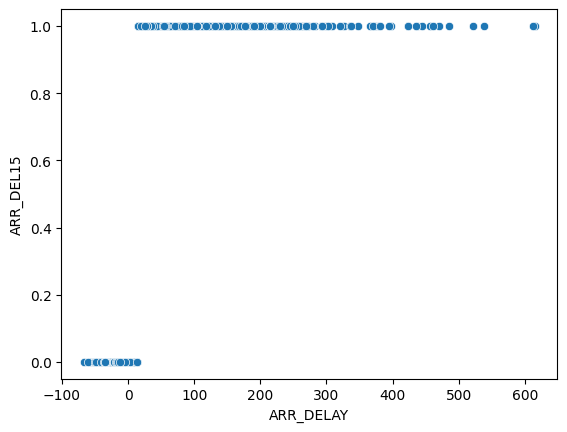

In [ ]:
sns.scatterplot(x='ARR_DELAY',y='ARR_DEL15',data=dataset)

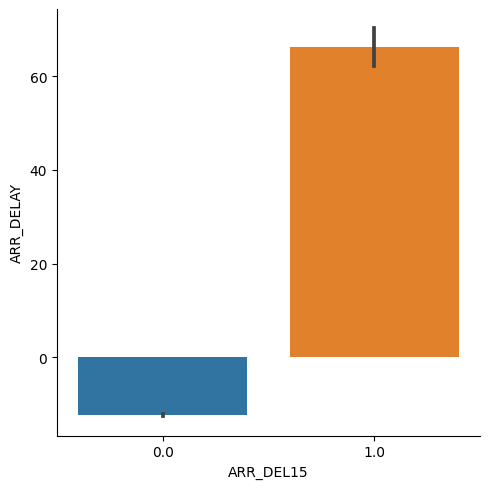

In [ ]:
sns.catplot(x="ARR_DEL15",y="ARR_DELAY",kind='bar',data=dataset)

<Axes: >

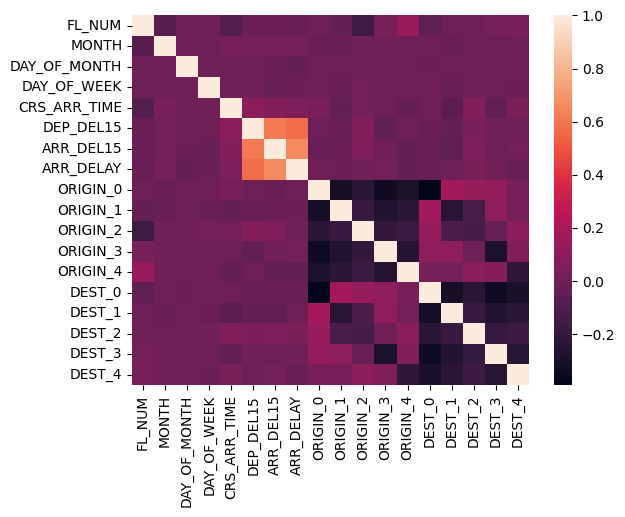

In [ ]:
sns.heatmap(dataset.corr())

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(dataset.drop('ARR_DELAY', axis=1), dataset['ARR_DEL15'], test_size=0.2, random_state=0)

In [ ]:
x_test.shape

(2247, 6)

In [ ]:
x_train.shape

(8984, 6)

In [ ]:
y_test.shape

(2247, 1)

In [ ]:
y_train.shape

(8984, 1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
x_train=np.nan_to_num(x_train)
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
x_test=np.nan_to_num(x_test)
decisiontree = classifier.predict(x_test)

In [ ]:
decisiontree

array([0, 0, 1, ..., 0, 1, 0], dtype=uint8)

In [ ]:
from sklearn.metrics import accuracy_score
desacc = accuracy_score(y_test,decisiontree)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy')

In [ ]:
rfc.fit(x_train,y_train)

<ipython-input-47-b87bb2ba9825>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train,y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10)

In [ ]:
y_predict = rfc.predict(x_test)

In [ ]:
# importing the keras libraries and packages
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# creating ANN skleton view

classification = Sequential()
classification.add(Dense(30,activation='relu'))
classification.add(Dense(128,activation='relu'))
classification.add(Dense(64,activation='relu'))
classification.add(Dense(32,activation='relu'))
classification.add(Dense(1,activation='sigmoid'))

In [ ]:
# compilling the ANN model

classification.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# Training the model

classification.fit(x_train,y_train,batch_size=4,validation_split=0.2,epochs=100)

Epoch 1/100
1797/1797 [==============================] - 8s 3ms/step - loss: 0.5891 - accuracy: 0.7258 - val_loss: 0.5830 - val_accuracy: 0.7234
Epoch 2/100
1797/1797 [==============================] - 6s 4ms/step - loss: 0.5787 - accuracy: 0.7258 - val_loss: 0.5808 - val_accuracy: 0.7234
Epoch 3/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.5710 - accuracy: 0.7258 - val_loss: 0.5729 - val_accuracy: 0.7234
Epoch 4/100
1797/1797 [==============================] - 6s 3ms/step - loss: 0.5645 - accuracy: 0.7278 - val_loss: 0.5763 - val_accuracy: 0.7229
Epoch 5/100
1797/1797 [==============================] - 6s 3ms/step - loss: 0.5620 - accuracy: 0.7290 - val_loss: 0.5720 - val_accuracy: 0.7268
Epoch 6/100
1797/1797 [==============================] - 7s 4ms/step - loss: 0.5602 - accuracy: 0.7310 - val_loss: 0.5787 - val_accuracy: 0.7334
Epoch 7/100
1797/1797 [==============================] - 6s 3ms/step - loss: 0.5594 - accuracy: 0.7308 - val_loss: 0.5686 - val_ac

In [ ]:
## Decision tree

y_pred = classifier.predict([[129,99,1,0,0,1]])

print(y_pred)
(y_pred)

[1]


array([1], dtype=uint8)

In [ ]:
from sklearn.metrics import accuracy_score
desacc=accuracy_score(y_test,decisiontree)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=10,criterion='entropy')

y_pred = classification.predict(x_test)

71/71 [==============================] - 0s 2ms/step


In [ ]:
rfc.fit(x_train,y_train)

<ipython-input-56-b87bb2ba9825>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train,y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10)

In [ ]:
y_predict=rfc.predict(x_test)

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
classification=Sequential()
classification.add(Dense(30,activation='relu'))
classification.add(Dense(128,activation='relu'))
classification.add(Dense(64,activation='relu'))
classification.add(Dense(32,activation='relu'))
classification.add(Dense(1,activation='sigmoid'))

In [ ]:
classification.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
classification.fit(x_train,y_train,batch_size=4,validation_split=0.2,epochs=100)

Epoch 1/100
1797/1797 [==============================] - 7s 3ms/step - loss: 0.5899 - accuracy: 0.7258 - val_loss: 0.5842 - val_accuracy: 0.7234
Epoch 2/100
1797/1797 [==============================] - 6s 3ms/step - loss: 0.5776 - accuracy: 0.7258 - val_loss: 0.5857 - val_accuracy: 0.7234
Epoch 3/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.5721 - accuracy: 0.7262 - val_loss: 0.5750 - val_accuracy: 0.7234
Epoch 4/100
1797/1797 [==============================] - 6s 4ms/step - loss: 0.5658 - accuracy: 0.7246 - val_loss: 0.5771 - val_accuracy: 0.7223
Epoch 5/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.5630 - accuracy: 0.7241 - val_loss: 0.5737 - val_accuracy: 0.7240
Epoch 6/100
1797/1797 [==============================] - 7s 4ms/step - loss: 0.5595 - accuracy: 0.7299 - val_loss: 0.5720 - val_accuracy: 0.7201
Epoch 7/100
1797/1797 [==============================] - 5s 3ms/step - loss: 0.5578 - accuracy: 0.7285 - val_loss: 0.5753 - val_ac

In [ ]:
y_pred=classifier.predict([[129,99,1,0,0,1]])
print(y_pred)
(y_pred)

[1]


array([1], dtype=uint8)

In [ ]:
classification.save('flight.h5')

In [ ]:
y_pred=classification.predict(x_test)

71/71 [==============================] - 0s 2ms/step


In [ ]:
y_pred

array([[0.3743789 ],
       [0.16885935],
       [0.20930506],
       ...,
       [0.71507645],
       [0.13552849],
       [0.52814734]], dtype=float32)

In [ ]:
y_pred=(y_pred>0.5)
y_pred

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [ True]])

In [ ]:
def predict_exist(sample_value):
  sample_value=np.array(sample_value)
  sample_value=sample_value.reshape(1,-1)
  sample_value=sc.transform(sample_value)
  return classifier.predict(sample_value)

In [ ]:
test=classification.predict([[1,1,121.000000,36.0,0,0]])
if test==1:
  print('Prediction: Chance of delay')
else:
  print('Prediction: No chance of delay.')

1/1 [==============================] - 0s 45ms/step
Prediction: No chance of delay.


In [ ]:
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier

In [ ]:
  dfs=[]
models=[
    ('RF',RandomForestClassifier()),
    ('DecisionTree',DecisionTreeClassifier()),
    ('ANN',MLPClassifier())
    ]
results=[]
  names=[]
  scoring=['accuracy','precision_weighted','recall_weighted','f1_weighted','roc_auc']
  target_names=['no delay','delay']
  for name,model in models:
    kfold=model_selection.KFold(n_splits=2,shuffle=True,random_state=90210)
    cv_results=model_selection.cross_validate(model,x_train,y_train,cv=kfold,scoring=scoring)
    clf=model.fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    print(name)
    print(classification_report(y_test,y_pred,target_names=target_names))
    results.append(name)
    this_df=pd.DataFrame(cv_results)
    this_df['model']=name
    dfs.append(this_df)
    final=pd.concat(dfs,ignore_index=True)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
<ipython-input-70-8c5cc9f29731>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf=model.fit(x_train,y_train)


RF
              precision    recall  f1-score   support

    no delay       0.79      0.95      0.87      1615
       delay       0.75      0.37      0.50       632

    accuracy                           0.79      2247
   macro avg       0.77      0.66      0.68      2247
weighted avg       0.78      0.79      0.76      2247

DecisionTree
              precision    recall  f1-score   support

    no delay       0.97      0.97      0.97      1615
       delay       0.93      0.93      0.93       632

    accuracy                           0.96      2247
   macro avg       0.95      0.95      0.95      2247
weighted avg       0.96      0.96      0.96      2247



/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

ANN
              precision    recall  f1-score   support

    no delay       0.73      0.97      0.83      1615
       delay       0.52      0.07      0.13       632

    accuracy                           0.72      2247
   macro avg       0.63      0.52      0.48      2247
weighted avg       0.67      0.72      0.64      2247



In [ ]:
from sklearn.metrics import accuracy_score
print('Testing accuracy:',accuracy_score(y_test,y_predict))

Testing accuracy: 0.7645749888740543


In [ ]:
#Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predict)
cm

array([[1516,   99],
       [ 430,  202]])

In [ ]:
#Accuracy score of desicionTree
from sklearn.metrics import accuracy_score
desacc = accuracy_score(y_test,decisiontree)

In [ ]:
desacc

0.956386292834891

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,decisiontree)

In [ ]:
cm

array([[1562,   53],
       [  45,  587]])

In [ ]:
# Calculate the Accuracy of ANN
from sklearn.metrics import accuracy_score,classification_report
score = accuracy_score(y_pred,y_test)
print('The accuracy for ANN model is: {}%'.format(score*100))

The accuracy for ANN model is: 72.051624388073%


In [ ]:
#Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1573,   42],
       [ 586,   46]])

In [ ]:
# giving some parameters that can be used in randized search cv
parameters = {
               'n_estimators' : [1,20,30,55,68,74,90,120,115],
                 'criterion': ['gini','entropy'],
                 'max_features' : ["auto","sqrd","log2"],
        'max_depth' : [2,5,8,10],'verbose' : [1,2,3,4,6,8,9,10]

        
}

In [ ]:
#performing the randomized cv
RCV = RandomizedSearchCV(estimator=rfc,param_distributions=parameters,cv=10,n_iter=4)

In [ ]:
RCV.fit(x_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_f

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tree 54 of 55
building tree 55 of 55
building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tree 54 of 55
building tree 55 of 55
building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tr

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 4 of 55
building tree 5 of 55
building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 6 of 55
building tree 7 of 55
building tree 8 of 55
building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 4

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 9 of 55
building tree 10 of 55
building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tre

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 11 of 55
building tree 12 of 55
building tree 13 of 55
building tree 14 of 55
building tree 15 of 55
building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tr

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 16 of 55
building tree 17 of 55
building tree 18 of 55
building tree 19 of 55
building tree 20 of 55
building tree 21 of 55
building tree 22 of 55
building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tree 54 of 55
building tree 55 of 55
building tree 1 of 55
building tree 2 of 55
building tree 3 of 55
building tree 

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 23 of 55
building tree 24 of 55
building tree 25 of 55
building tree 26 of 55
building tree 27 of 55
building tree 28 of 55
building tree 29 of 55
building tree 30 of 55
building tree 31 of 55
building tree 32 of 55
building tree 33 of 55
building tree 34 of 55
building tree 35 of 55
building tree 36 of 55
building tree 37 of 55
building tree 38 of 55
building tree 39 of 55
building tree 40 of 55
building tree 41 of 55
building tree 42 of 55
building tree 43 of 55
building tree 44 of 55
building tree 45 of 55
building tree 46 of 55
building tree 47 of 55
building tree 48 of 55
building tree 49 of 55
building tree 50 of 55
building tree 51 of 55
building tree 52 of 55
building tree 53 of 55
building tree 54 of 55
building tree 55 of 55


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 of 115
building tree 51 of 115
building tree 52 of 115
building tree 53 of 115
building tree 54 of 115
building tree 55 of 115
building tree 56 of 115
building tree 57 of 115
building tree 58 of 115
building tree 59 of 115
building tree 60 of 115
building tree 61 of 115
building tree 62

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 of 115
building tree 51 of 115
building tree 52 of 115
building tree 53 of 115
building tree 54 of 115
building tree 55 of 115
building tree 56 of 115
building tree 57 of 115
building tree 58 of 115
building tree 59 of 115
building tree 60 of 115
building tree 61 of 115
building tree 62

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 of 115
building tree 51 of 115
building tree 52 of 115
building tree 53 of 115
building tree 54 of 115
building tree 55 of 115
building tree 56 of 115
building tree 57 of 115
building tree 58 of 115
building tree 59

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
building tree 43 of 115
building tree 44 of 115
building tree 45 of 115
building tree 46 of 115
building tree 47 of 115
building tree 48 of 115
building tree 49 of 115
building tree 50 of 115
building tree 51 of 115
building tree 52 of 115
building tree 53 of 115
building tree 54 of 115
building tree 55 of 115
building tree 56 of 115
building tree 57 of 115
building tree 58 of 115
building tree 59 of 115
building tree 60 of 115
building tree 61 of 115
building tree 62 of 115
building tree 63 of 115
building tree 64 of 115
building tree 65 of 115
building tree 66

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 115
building tree 2 of 115
building tree 3 of 115
building tree 4 of 115
building tree 5 of 115
building tree 6 of 115
building tree 7 of 115
building tree 8 of 115
building tree 9 of 115
building tree 10 of 115
building tree 11 of 115
building tree 12 of 115
building tree 13 of 115
building tree 14 of 115
building tree 15 of 115
building tree 16 of 115
building tree 17 of 115
building tree 18 of 115
building tree 19 of 115
building tree 20 of 115
building tree 21 of 115
building tree 22 of 115
building tree 23 of 115
building tree 24 of 115
building tree 25 of 115
building tree 26 of 115
building tree 27 of 115
building tree 28 of 115
building tree 29 of 115
building tree 30 of 115
building tree 31 of 115
building tree 32 of 115
building tree 33 of 115
building tree 34 of 115
building tree 35 of 115
building tree 36 of 115
building tree 37 of 115
building tree 38 of 115
building tree 39 of 115
building tree 40 of 115
building tree 41 of 115
building tree 42 of 115
b

[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=10),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrd',
                                                         'log2'],
                                        'n_estimators': [1, 20, 30, 55, 68, 74,
                                                         90, 120, 115],
                                        'verbose': [1, 2, 3, 4, 6, 8, 9, 10]})

In [ ]:
#getting the best paarmets from the giving list and best score from them\
bt_params = RCV.best_params_
bt_score = RCV.best_score_

In [ ]:
bt_params

{'verbose': 6,
 'n_estimators': 74,
 'max_features': 'log2',
 'max_depth': 5,
 'criterion': 'gini'}

In [ ]:
bt_score

0.7264025110801162

In [ ]:
model = RandomForestClassifier(verbose= 10, n_estimators= 120, max_features= 'log2',max_depth= 10,criterion= 'entropy')
RCV.fit(x_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 con

building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_select

building tree 1 of 90
building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 90
building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 90
building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tre

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tr

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter


building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter

building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as i

building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
b

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.1s finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=10),
                   n_iter=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 10],
                                        'max_features': ['auto', 'sqrd',
                                                         'log2'],
                                        'n_estimators': [1, 20, 30, 55, 68, 74,
                                                         90, 120, 115],
                                        'verbose': [1, 2, 3, 4, 6, 8, 9, 10]})

In [ ]:
y_predict_rf = RCV.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.3s finished


In [ ]:
RFC=accuracy_score(y_test,y_predict_rf)
RFC

0.7534490431686693

In [ ]:
import pickle
pickle.dump(RCV,open('flight.pkl','wb'))

In [ ]:
# importing the necessary dependencies
from flask import Flask,request,render_template
import numpy as np
import pandas as pd
import pickle
import os

In [ ]:
model = pickle.load(open('flight.pkl','rb'))
app = Flask(__name__)#initializing the app

In [ ]:
@app.route('/',methods=['POST'])
def home():
    return render_template("index.html")

In [ ]:
from re import I
def predict():
  name = request.form['name']
  month = request.form['month']
  dayofmonth = request.form['dayofmonth']
  dayofweek = request.form['dayofweek']
  origin = request.form['origin']
  if(origin == 'msp'):
    origin1,origin2,origin3,origin4,origin5 = 0,0,0,0,1
  if(origin == 'dtw'):
    origin1,origin2,origin3,origin4,origin5 = 1,0,0,0,0
  if(origin == 'jfk'):
    origin1,origin2,origin3,origin4,origin5 = 0,0,1,0,0
  if(origin == 'sea'):
    origin1,origin2,origin3,origin4,origin5 = 0,1,0,0,0
  if(origin == "alt"):
    origin1,origin2,origin3,origin4,origin5 = 0,0,0,1,0
  destination = request.form['destination']
  if(destination == "msp"):
    destination1,destination2,destination3,destination4,destination5 = 0,0,0,0,1
  if(destination == "dtw"):
    destination1,destination2,destination3,destination4,destination5 = 1,0,0,0,0
  if(destination == "jfk"):
    destination1,destination2,destination3,destination4,destination5 = 0,0,1,0,0
  if(destination == "sea"):
    destination1,destination2,destination3,destination4,destination5 = 0,1,0,0,0
  if(destination == "alt"):
    destination1,destination2,destination3,destination4,destination5 = 0,0,0,1,0
  dept = request.form['dept']
  arrtime = request.form['arrtime']
  actdept = request.form['actdept']
  dept15=int(dept)-int(actdept)
  total=[[name,month,dayofmonth,dayofweek,origin1,origin2,origin3,origin4,origin5,destination1,destination2,destination3,destination4,destination5,i]]
  #print(total)
  y_pred = model.predict(total)
  print(y_pred)
  if(y_pred==[0,1]):
    ans="The Flight will be on time"
  else:
    ans="The Flight will be delayed"
  return render_template("index.html",showcase = ans)

In [ ]:
if __name__ == '__main__':
  app.run(debug = True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
